# Sinusoidal Frequency Estimation by Gradient Descent


It is becoming increasingly popular to incorporate signal generators and processors into neural network architecures. When implemented via differentiable programming, networks can be trained to control signal processors with defined gradients using standard first order optimizers. This technique is commonly known as [Differentiable Digital Signal Processing (DDSP)](https://magenta.tensorflow.org/ddsp). But there’s a problem… a pretty fundamental operation in many audio signal processing tasks — namely, matching the frequency of a sinusoid — can not be easily solved this way. Just look at what happens when we try to use gradient descent to find the frequency of a single differentiable sinusoid…

In [1]:
import torch
import math
import matplotlib.pyplot as plt

In [2]:
N = 64
n = torch.arange(N)

torch.random.manual_seed(1000)
predicted_freq = (torch.rand(1) * math.pi).requires_grad_()
print(f"Starting frequency: {predicted_freq.item():.3f}")

target_freq = torch.tensor(0.25)
target_signal = torch.cos(target_freq * n)

criterion = torch.nn.MSELoss()
optimiser = torch.optim.SGD([predicted_freq], lr=3e-4)

for step in range(5000):
    predicted_signal = torch.cos(predicted_freq * n)
    loss = criterion(predicted_signal, target_signal)

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    if (step + 1) % 1000 == 0:
        print(f"--- Step: {step + 1} ---")
        print(f"Predicted frequency: {predicted_freq.item():.3f}")
        print(f"Target frequency: {target_freq.item():.3f}")

Starting frequency: 1.002
--- Step: 1000 ---
Predicted frequency: 0.969
Target frequency: 0.250
--- Step: 2000 ---
Predicted frequency: 0.969
Target frequency: 0.250
--- Step: 3000 ---
Predicted frequency: 0.969
Target frequency: 0.250
--- Step: 4000 ---
Predicted frequency: 0.969
Target frequency: 0.250
--- Step: 5000 ---
Predicted frequency: 0.969
Target frequency: 0.250


We can start at almost any value of `predicted_freq` and we’ll still end up failing to find the correct frequency. [Our paper](https://arxiv.org/abs/2210.14476) goes into more detail about why this happens, but suffice it to say that this prevents DDSP techniques from being applied to many tasks. This work aims to resolve this issue. We do so by replacing the differentiable sinusoid with a surrogate: the real part of an exponentiated complex number. This gives us an exponentially decaying sinusoid, and the Wirtinger derivatives of this operation in the complex plane lead our optimizer to the correct solution.  For example:

In [3]:
from sinusoidal_gradient_descent.core import complex_oscillator

N = 64
n = torch.arange(N)

torch.random.manual_seed(1000)
starting_freq = torch.rand(1) * math.pi
predicted_z = torch.exp(1j * starting_freq)
predicted_z.detach_().requires_grad_(True)
print(f"Starting frequency: {predicted_z.angle().abs().item():.3f}")

target_freq = torch.tensor(0.1)
target_signal = torch.cos(target_freq * n)

criterion = torch.nn.MSELoss()
optimiser = torch.optim.SGD([predicted_z], lr=3e-4)

for step in range(5000):
    predicted_signal = complex_oscillator(predicted_z, N=N, reduce=True)
    loss = criterion(predicted_signal, target_signal)

    optimiser.zero_grad()
    loss.backward()
    predicted_z.grad = predicted_z.grad / predicted_z.grad.abs()
    optimiser.step()

    if (step + 1) % 1000 == 0:
        print(f"--- Step: {step + 1} ---")
        print(f"Predicted frequency: {predicted_z.angle().abs().item():.3f}")
        print(f"Target frequency: {target_freq.item():.3f}")


Starting frequency: 1.002
--- Step: 1000 ---
Predicted frequency: 0.970
Target frequency: 0.100
--- Step: 2000 ---
Predicted frequency: 0.594
Target frequency: 0.100
--- Step: 3000 ---
Predicted frequency: 0.131
Target frequency: 0.100
--- Step: 4000 ---
Predicted frequency: 0.091
Target frequency: 0.100
--- Step: 5000 ---
Predicted frequency: 0.100
Target frequency: 0.100


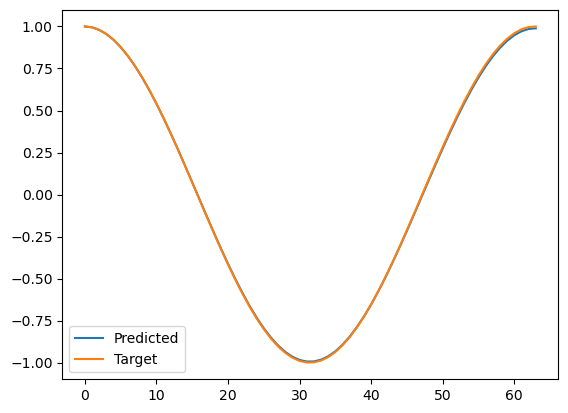

In [4]:
plt.plot(predicted_signal.detach().numpy())
plt.plot(target_signal)
plt.legend(['Predicted','Target'])
plt.show()

## Implementations

The complex surrogate described in the paper can be easily implemented in PyTorch in a number of ways. We present three of these below as reference implementations. In all cases, for a complex parameter, PyTorch computes the Wirtinger derivative by default, meaning that no custom backward pass is necessary. [Click here for more info](https://pytorch.org/docs/stable/notes/autogradhtml#autograd-for-complex-numbers).

In [5]:
N = 64
freq = torch.tensor(0.7)
cosine_reference = torch.cos(freq * torch.arange(N))

z = torch.exp(1j * freq)  # complex parameter

### Implementation 1: direct exponentiation

This implementation produces the signal exactly as described in the paper: by taking the exponential of $z$. The major downside here is that numerical instability can become an issue for values of $z>1$.


In [6]:
def complex_oscillator_direct(z: torch.complex, N: int):
    """Implements the complex surrogate by direct exponentiation."""
    n = torch.arange(N)
    return (z ** n).real

direct_osc_output = complex_oscillator_direct(z, N)

torch.testing.assert_close(direct_osc_output, cosine_reference)

Timing the operation on an Intel i5 2GHz Quad Core CPU:

15 µs ± 740 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

### Implementation 2: cumulative product

This implementation takes the cumulative product across a time series of complex parameters $z_{1:N}$. As with direct exponentiation, instability can become an issue, as can loss of precision. The advantage of this approach, however, is that it can be extended to a time-varying
parameter.

Note that here we prepend the sequence with an initial $1$ to correspond to $z^0$, and thus truncate the final entry of $z$, retaining only $z_{1:N-1}$.

In [7]:
def complex_oscillator_cumprod(z: torch.complex):
    """Implements the complex surrogate by taking the cumulative product along the time
    dimension."""
    initial = torch.ones(*z.shape[:-1], 1, dtype=z.dtype, device=z.device)
    z_cat = torch.cat([initial, z], dim=-1)[:-1]

    return torch.cumprod(z_cat, dim=-1).real

cumprod_osc_output = complex_oscillator_cumprod(z.repeat(N))

torch.testing.assert_close(cumprod_osc_output, cosine_reference)

Timing the operation on an Intel i5 2GHz Quad Core CPU:

18.3 µs ± 904 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

### Implementation 3: directly damped sinusoid

This implementation limits the issues with numerical stability to only the amplitude parameter by instead explicitly computing the parameters of the damped sinusoidal equivalent of the surrogate. This could further be adapted to time-varying $z$ by utilising a cumulative summation to compute the sinusoid’s phase and a cumulative product to compute instantaneous amplitude. Adopting an angular cumsum operation to accumulate sinusoidal phase would further improve numerical precision.

In [8]:
def complex_oscillator_damped(z: torch.complex, N: int):
    """Implements the complex surrogate by explicitly computing the parameters of the
    damped sinusoid equivalent."""
    n = torch.arange(N)
    return (z.abs() ** n) * torch.cos(z.angle() * n)

damped_osc_output = complex_oscillator_damped(z, N)

torch.testing.assert_close(damped_osc_output, cosine_reference)

Timing the operation on an Intel i5 2GHz Quad Core CPU:


27.2 µs ± 346 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

## Running this code

To run the code and reproduce our experiments, we recommend installing the package inside a virtual environment of your choice:

``` bash
git clone https://github.com/ben-hayes/sinusoidal-gradient-descent.git
cd sinusoidal-gradient-descent
conda create --name sin-gd
conda activate sin-gd
pip install -e .
```

You will also need to ensure you have a version of PyTorch appropriate to your platform installed. See [here for more
information](https://pytorch.org/get-started/locally/).

The experiments can then be run using the `evaluate_estimator` script:

``` bash
evaluate_estimator -cn multi_fft_2
```

Substitute `multi_fft_2` for any of the configuration names from the
`estimator_config` directory to run different experiments.

#### On nbdev

This project’s code was written using [nbdev](https://nbdev.fast.ai/), which allows Python modules to be created with accompanying documentation in a fast notebook-style workflow. Our code can therefore either be explored in module form (in the `sinusoidal_gradient_descent`) folder, in notebook form (in the `nbs` folder), or [as a website](https://benhayes.net/sinusoidal-gradient-descent).